# The Cable Equation: Modeling Neuronal Signal Propagation

This notebook explores the one-dimensional cable equation, a fundamental model in computational neuroscience used to describe the passive spread of electrical signals (voltage) along a neuron's dendrite or axon.

**Biological Context:**

Neurons communicate by transmitting electrical signals. The cable equation simplifies the complex geometry of a neuron into a cylindrical "cable" and allows us to understand:
-   **Passive Spread**: How local voltage changes (e.g., from synaptic input) decay and spread along the neural membrane.
-   **Space Constant (λ)**: A crucial parameter representing the distance over which a voltage signal attenuates to approximately 37% of its original amplitude. Longer length constants imply more effective passive signal propagation.
-   **Time Constant (τ)**: A parameter describing how quickly the membrane voltage responds to a change in current. It reflects the inherent capacitance and resistance of the neuronal membrane.

This notebook visualizes the solution of the cable equation solved using a Physics-Informed Neural Network (PINN) and provides interactive tools to understand its dynamics.


### Key Parameters of the Cable Equation

The cable equation is governed by several key physical and physiological parameters:

-   **Membrane Time Constant (τ)**: This parameter represents how quickly the membrane potential of a neuron changes in response to a step change in current. It is determined by the membrane resistance (R_m) and membrane capacitance (C_m) (τ = R_m * C_m). A larger τ means the membrane potential changes more slowly.

-   **Membrane Length Constant (λ)**: This parameter describes how far a steady-state voltage change will spread along a cable before it decays to 1/e (approximately 37%) of its original amplitude. It is determined by the membrane resistance (R_m) and axial resistance (R_a) (λ = sqrt(R_m / R_a)). A larger λ means the signal propagates further passively.


Y min: -70.33, Y max: -4.92, Y shape: (101, 101)


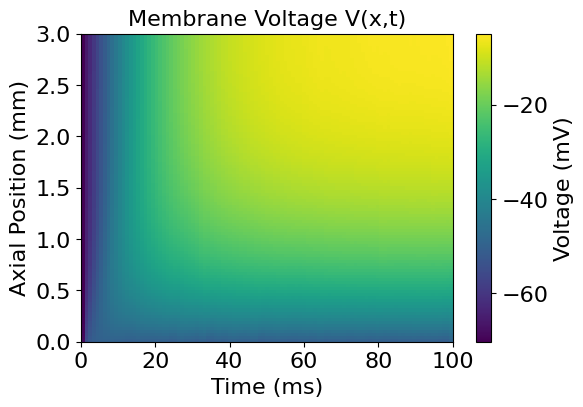

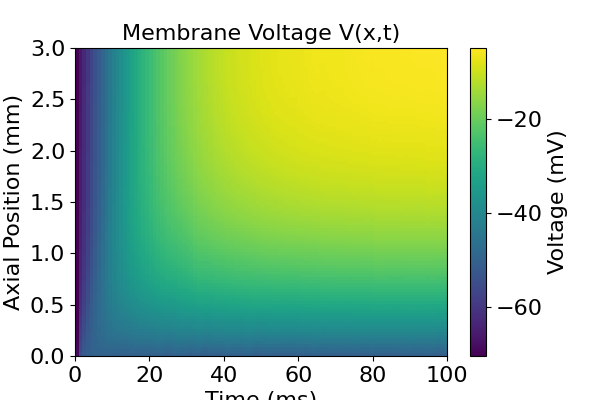

In [1]:
%matplotlib widget

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import tensor

from measure_uq.models import PINN
from measure_uq.pde import PDE
from measure_uq.utilities import cartesian_product_of_rows, to_numpy
from examples.equations.cable_pde.pde import Residual, ModelParameters

mpl.rcParams.update(
    {
        "text.usetex": False,
        "font.family": "STIX",
        "mathtext.fontset": "stix",
        "font.size": 16,
        "axes.titlesize": 16,
        "axes.labelsize": 16,
        "xtick.labelsize": 16,
        "ytick.labelsize": 16,
        "legend.fontsize": 16,
        "figure.titlesize": 16,
    }
)

# Load
model = PINN.load('data/best_model_cable_pinn.pickle')
pde = PDE.load('data/pde_cable_pinn.pickle')

T = pde.conditions_train.conditions[0].T_max
L = pde.conditions_train.conditions[0].L_max

t = tensor(np.linspace(0, T, 101)[:, None]).float()
x = tensor(np.linspace(0, L, 101)[:, None]).float()
tx = cartesian_product_of_rows(t, x).float()

# Parameters are fixed and stored in pde.parameters_test
params = pde.parameters_test.values

_, y = model.forward(tx, params)
Y = y.detach().cpu().numpy().reshape(101, 101).T  # shape (Nx, Nt)

print(f"Y min: {Y.min():.2f}, Y max: {Y.max():.2f}, Y shape: {Y.shape}")

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
im = ax.imshow(
    Y,
    origin='lower',
    aspect='auto',
    extent=[0, T, 0, L],
    cmap='viridis',
)
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Axial Position (mm)')
ax.set_title('Membrane Voltage V(x,t)')
fig.colorbar(im, ax=ax, label='Voltage (mV)')
display(fig)


### Snapshots and temporal traces
Static snapshots of V(x,t) at selected times and traces over time at fixed locations.


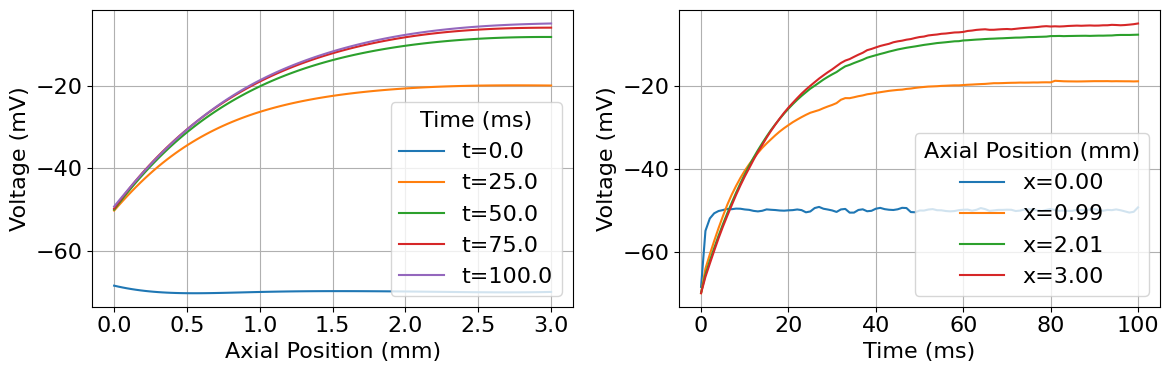

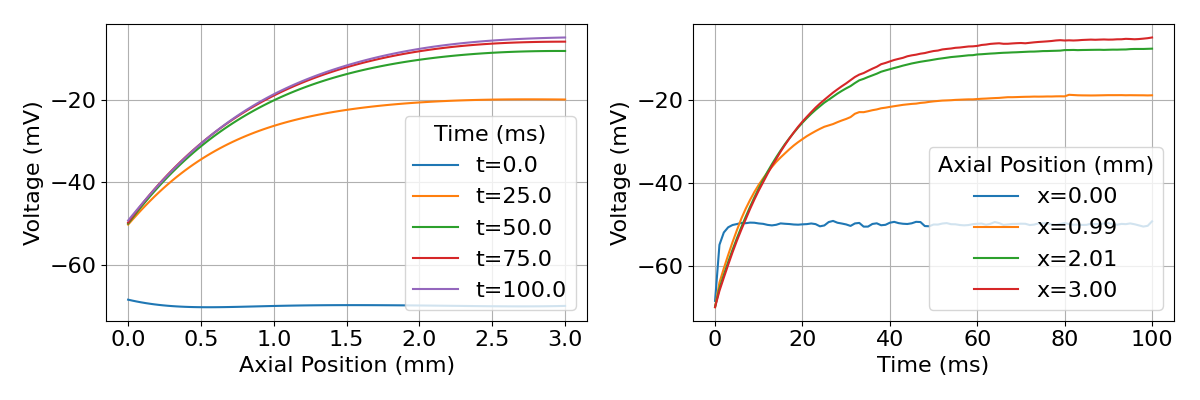

In [2]:
# Static snapshots at multiple times and temporal traces at fixed x's
import numpy as np
import matplotlib.pyplot as plt

TT = to_numpy(t).squeeze()
XX = to_numpy(x).squeeze()

# V(x,t) already computed as Y (Nx, Nt)
# Snapshots
idx_times = np.linspace(0, len(TT)-1, 5, dtype=int)
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
for i in idx_times:
    axs[0].plot(XX, Y[:, i], label=f't={TT[i]:.1f}')
axs[0].set_xlabel('Axial Position (mm)'); axs[0].set_ylabel('Voltage (mV)'); axs[0].grid(True); axs[0].legend(title='Time (ms)')

# Traces at fixed x
x_positions = np.linspace(XX.min(), XX.max(), 4)
for xstar in x_positions:
    ix = int(np.argmin(np.abs(XX - xstar)))
    axs[1].plot(TT, Y[ix, :], label=f'x={XX[ix]:.2f}')
axs[1].set_xlabel('Time (ms)'); axs[1].set_ylabel('Voltage (mV)'); axs[1].grid(True); axs[1].legend(title='Axial Position (mm)')
fig.tight_layout()
display(fig)


### Animated propagation
Animation of V(x,t) propagation across x as time advances.


In [3]:
# Animation: line plot over x that updates with time
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

plt.close('all')
fig, ax = plt.subplots(figsize=(8, 4))
(line,) = ax.plot(XX, Y[:, 0], lw=2)
ax.set_ylim(1.05 * Y.min(), 1.05 * Y.max())
ax.set_xlabel('x'); ax.set_ylabel('V'); ax.grid(True)

def animate(i):
    line.set_ydata(Y[:, i])
    ax.set_title(f't={TT[i]:.2f}')
    return (line,)

anim = FuncAnimation(fig, animate, frames=Y.shape[1], interval=100, blit=True)
plt.close(fig) # Close the figure explicitly after animation object is created
HTML(anim.to_html5_video())


### Interactive slices and parameter tweaks
Use sliders to scrub through time and select spatial position. Also adjust parameters (τ, λ, V_rest, V_inject) to compare model response; note the trained model uses fixed parameters so these controls only affect an analytical reference and the boundary nullcline overlays.


In [4]:
# Interactive: sliders for time and space, with simple reference and overlays
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

TT = to_numpy(t).squeeze()
XX = to_numpy(x).squeeze()

s_t = widgets.IntSlider(value=0, min=0, max=len(TT)-1, step=1, description='t index', continuous_update=False)
s_x = widgets.FloatSlider(value=float(XX[len(XX)//2]), min=float(XX.min()), max=float(XX.max()), step=float(XX[1]-XX[0]), description='x*', readout_format='.2f', continuous_update=False)

output_slices = widgets.Output()

def _update_slices(t_index, xstar):
    with output_slices:
        clear_output(wait=True)
        fig_slices, axs_slices = plt.subplots(1, 2, figsize=(12, 4))
        
        # Update slice over x at time
        axs_slices[0].plot(XX, Y[:, t_index], lw=2)
        axs_slices[0].axvline(xstar, color='k', ls=':')
        axs_slices[0].set_xlabel('Axial Position (mm)'); axs_slices[0].set_ylabel('Voltage (mV)'); axs_slices[0].grid(True)
        axs_slices[0].set_title(f'Voltage profile along x at t={TT[t_index]:.2f} ms')

        # Update slice over t at x*
        ix = int(np.argmin(np.abs(XX - xstar)))
        axs_slices[1].plot(TT, Y[ix, :], lw=2)
        axs_slices[1].axvline(TT[t_index], color='k', ls=':')
        axs_slices[1].set_xlabel('Time (ms)'); axs_slices[1].set_ylabel('Voltage (mV)'); axs_slices[1].grid(True)
        axs_slices[1].set_title(f'Voltage trace over time at x={XX[ix]:.2f} mm')
        
        fig_slices.tight_layout()
        display(fig_slices)
        plt.close(fig_slices) # Close the figure to prevent excessive memory usage

controls_slices = widgets.VBox([s_t, s_x])

_ = widgets.interactive(
    _update_slices,
    t_index=s_t,
    xstar=s_x,
)

display(controls_slices, output_slices)


Output()

### PDE residual heatmap
Visualize the absolute residual |τ V_t + V − λ² V_xx| across space–time to assess where the model struggles.


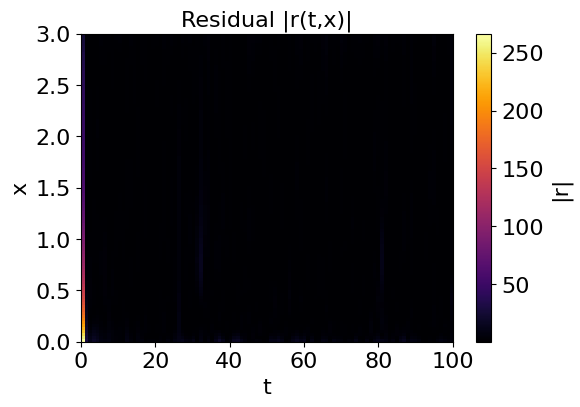

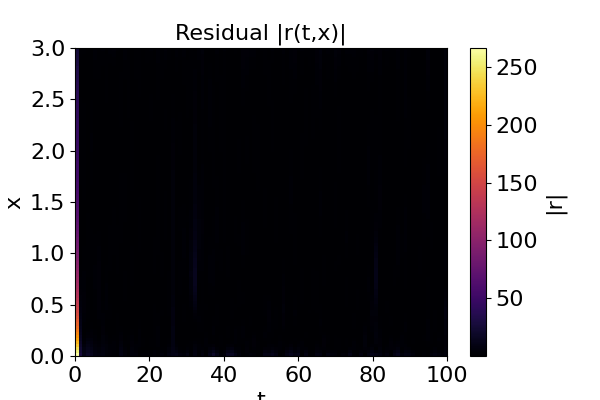

In [5]:
# Compute residual on the TX grid and plot its heatmap
import torch
from measure_uq.gradients import jacobian

plt.close('all')

params = pde.parameters_test.values  # shape (1,4)

TX = tx  # (Nt*Nx, 2)
TXP, Yp = model.forward(TX, params)

# Derivatives
with torch.enable_grad():
    TXP = TXP.detach().clone().requires_grad_(True)
    Yg = model.network(TXP)  # forward through network only
    dVdt = jacobian(Yg, TXP, j=0)
    dVdx = jacobian(Yg, TXP, j=1)
    d2Vdx2 = jacobian(dVdx, TXP, j=1)

# Unpack parameters from TXP columns
TAU = TXP[:, 2:3]
LAMB = TXP[:, 3:4]
RES = TAU * dVdt + Yg - (LAMB**2) * d2Vdx2
Res = Res_abs = Res_np = np.abs(RES.detach().cpu().numpy()).reshape(len(t), len(x)).T

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
im = ax.imshow(Res_np, origin='lower', aspect='auto', extent=[0, T, 0, L], cmap='inferno')
ax.set_xlabel('t'); ax.set_ylabel('x'); ax.set_title('Residual |r(t,x)|')
fig.colorbar(im, ax=ax, label='|r|')
display(fig)
plt.show()


### PDE residual over time
Visualize the average absolute residual |τ V_t + V − λ² V_xx| across time, averaged over spatial dimensions.


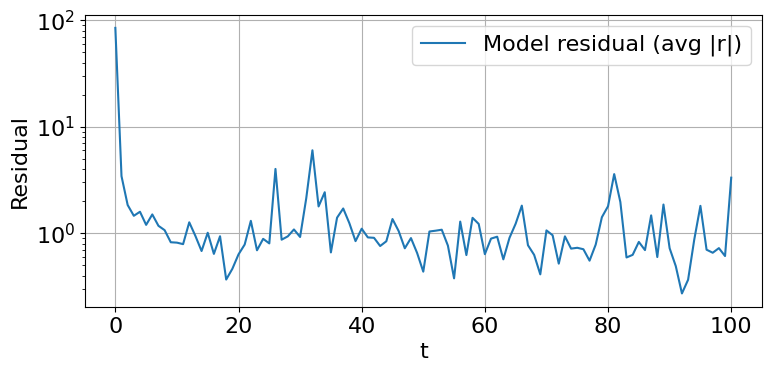

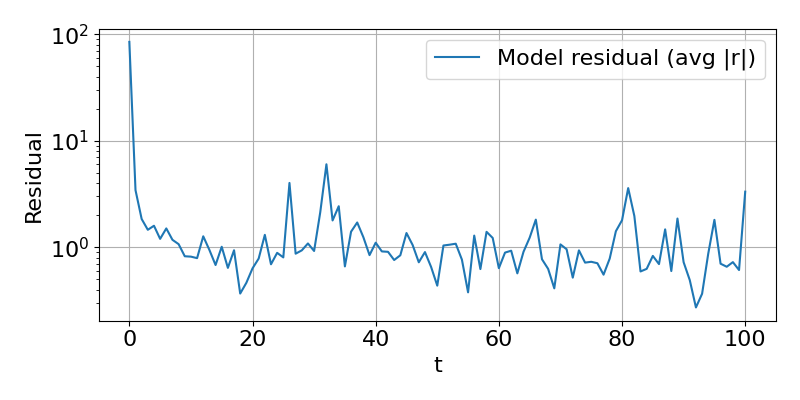

In [6]:
plt.close('all')

# Build a synthetic residual condition using the same T_max and L_max as in training defaults
cond = pde.conditions_train.conditions[0]
assert isinstance(cond, Residual)

# Ensure tx requires grad for Jacobian wrt t and x
tx_req = tx.clone().detach().requires_grad_(True)

# Model residual at the same (t, x, params)
txp, yp = model.forward(tx_req, params)  # params are fixed, so they are the same

r_model = cond.eval(txp, yp).detach().cpu().numpy().reshape(len(t), len(x)).T

# Average absolute residual per time index (average over space)
r_model_t = np.abs(r_model).mean(axis=0)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(TT, r_model_t, label='Model residual (avg |r|)')
ax.set_yscale('log')
ax.set_xlabel('t')
ax.set_ylabel('Residual')
ax.grid(True)
ax.legend()
fig.tight_layout()
display(fig)

fig.savefig('cable_pde_residual_over_time.pdf', bbox_inches='tight', dpi=300)


### Linked interactive 2D viewer with crosshairs and slices
A 2D heatmap of V(x,t) with synchronized vertical (time) and horizontal (space) cursors and linked slice plots. Includes play/pause controls.Passi

In [7]:
# Interactive heatmap + synchronized slices + play controls
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt

plt.close('all')
TT = to_numpy(t).squeeze(); XX = to_numpy(x).squeeze()

output_heatmap = widgets.Output()

s_t_heatmap = widgets.IntSlider(value=0, min=0, max=Y.shape[1]-1, step=1, description='t index', continuous_update=False)
s_x_heatmap = widgets.IntSlider(value=Y.shape[0]//2, min=0, max=Y.shape[0]-1, step=1, description='x index', continuous_update=False)
play_heatmap = widgets.Play(interval=100, value=0, min=0, max=Y.shape[1]-1, step=1, description='Press play')
widgets.jslink((play_heatmap, 'value'), (s_t_heatmap, 'value'))

def _update_heatmap_view(t_index, x_index):
    with output_heatmap:
        clear_output(wait=True)
        fig_heatmap, axs_heatmap = plt.subplots(2, 2, figsize=(12, 8))
        axH_heatmap, axX_heatmap, axT_heatmap = axs_heatmap[0, 0], axs_heatmap[0, 1], axs_heatmap[1, 0]
        fig_heatmap.delaxes(axs_heatmap[1, 1])

        im_heatmap = axH_heatmap.imshow(Y, origin='lower', aspect='auto', extent=[0, T, 0, L], cmap='viridis')
        axH_heatmap.set_xlabel('Time (ms)'); axH_heatmap.set_ylabel('Axial Position (mm)'); axH_heatmap.set_title('Membrane Voltage V(x,t)')
        cb_heatmap = fig_heatmap.colorbar(im_heatmap, ax=axH_heatmap, label='Voltage (mV)')
        
        vh_heatmap = axH_heatmap.axhline(y=XX[x_index], color='w', ls=':')
        vv_heatmap = axH_heatmap.axvline(x=TT[t_index], color='w', ls=':')

        # Update slices
        axX_heatmap.plot(XX, Y[:, t_index]); axX_heatmap.set_title(f'Voltage profile along x at t={TT[t_index]:.2f} ms'); axX_heatmap.set_xlabel('Axial Position (mm)'); axX_heatmap.set_ylabel('Voltage (mV)'); axX_heatmap.grid(True)

        axT_heatmap.plot(TT, Y[x_index, :]); axT_heatmap.set_title(f'Voltage trace over time at x={XX[x_index]:.2f} mm'); axT_heatmap.set_xlabel('Time (ms)'); axT_heatmap.set_ylabel('Voltage (mV)');         axT_heatmap.set_ylim(1.05 * Y.min(), 1.05 * Y.max()); axT_heatmap.grid(True)

        fig_heatmap.tight_layout()
        display(fig_heatmap)
        plt.close(fig_heatmap) # Close the figure to prevent excessive memory usage

controls_heatmap = widgets.VBox([widgets.HBox([s_t_heatmap, play_heatmap]), s_x_heatmap])

_ = widgets.interactive(
    _update_heatmap_view,
    t_index=s_t_heatmap,
    x_index=s_x_heatmap,
)

display(controls_heatmap, output_heatmap)


Output()

### Interactive Parameter Explorer

This interactive plot allows you to explore how changing the physical parameters of the cable equation (membrane time constant τ, length constant λ, resting potential V_rest, and injected voltage V_inject) affects the steady-state voltage profile along the dendrite or the transient voltage response over time. The PINN solution will be re-evaluated on-the-fly for the chosen parameters.


In [8]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import torch

plt.close('all')

# Define sliders for the parameters
tau_slider = widgets.FloatSlider(value=float(pde.parameters_test.values[0, ModelParameters._TAU_IDX - 2]), min=1.0, max=50.0, step=1.0, description='τ (ms)', continuous_update=False)
lambda_slider = widgets.FloatSlider(value=float(pde.parameters_test.values[0, ModelParameters._LAMBDA_P_IDX - 2]), min=0.1, max=5.0, step=0.1, description='λ (mm)', continuous_update=False)
vrest_slider = widgets.FloatSlider(value=float(pde.parameters_test.values[0, ModelParameters._V_REST_IDX - 2]), min=-80.0, max=-50.0, step=1.0, description='V_rest (mV)', continuous_update=False)
vinject_slider = widgets.FloatSlider(value=float(pde.parameters_test.values[0, ModelParameters._V_INJECT_IDX - 2]), min=-70.0, max=-30.0, step=1.0, description='V_inject (mV)', continuous_update=False)

# Fixed time for the profile plot
t_fixed_idx = int(len(t) * 0.5) # Roughly mid-simulation
t_fixed = t[t_fixed_idx:t_fixed_idx+1, :]

# Create a dummy parameter tensor to use with model.combine_input
dummy_params_template = pde.parameters_test.values.clone().detach()

output_param_explorer = widgets.Output()

def _update_param_explorer(tau, lambda_p, v_rest, v_inject):
    with output_param_explorer:
        clear_output(wait=True)
        fig_param_explorer, ax_param_explorer = plt.subplots(1, 1, figsize=(10, 6))
        
        # Update the dummy parameter tensor with new slider values
        updated_params = dummy_params_template.clone()
        updated_params[0, ModelParameters._TAU_IDX - 2] = tau
        updated_params[0, ModelParameters._LAMBDA_P_IDX - 2] = lambda_p
        updated_params[0, ModelParameters._V_REST_IDX - 2] = v_rest
        updated_params[0, ModelParameters._V_INJECT_IDX - 2] = v_inject

        # Create (t, x) coordinates for evaluation
        t_repeated = t_fixed.repeat(len(XX), 1) # Shape (len(XX), 1)
        x_eval = torch.tensor(XX[:, None]).float()   # Shape (len(XX), 1)
        tx_coords = torch.cat((t_repeated, x_eval), dim=1) # Shape (len(XX), 2)
        
        # Repeat parameters for each (t, x) pair
        params_repeated_for_forward = updated_params.repeat(len(XX), 1) # Shape (len(XX), 4)

        # Manually combine inputs and pass directly to model.network
        z_combined = torch.cat((tx_coords, params_repeated_for_forward), dim=1)
        y_new = model.network(z_combined)
        
        # Explicitly reshape to ensure correct dimensions for plotting
        y_new_profile = y_new.detach().cpu().numpy().reshape(len(XX))

        ax_param_explorer.plot(XX, y_new_profile, lw=2)
        ax_param_explorer.set_xlabel('Axial Position (mm)')
        ax_param_explorer.set_ylabel('Voltage (mV)')
        ax_param_explorer.set_title(f'Voltage Profile at t={TT[t_fixed_idx]:.2f} ms (τ={tau:.1f}, λ={lambda_p:.1f})')
        ax_param_explorer.grid(True)
        ax_param_explorer.set_ylim(1.1 * Y.min(), 1.1 * Y.max())
        
        fig_param_explorer.tight_layout()
        display(fig_param_explorer)
        plt.close(fig_param_explorer) # Close the figure to prevent excessive memory usage

controls_param_explorer = widgets.VBox([
    tau_slider,
    lambda_slider,
    vrest_slider,
    vinject_slider,
])

_ = widgets.interactive(
    _update_param_explorer,
    tau=tau_slider,
    lambda_p=lambda_slider,
    v_rest=vrest_slider,
    v_inject=vinject_slider,
)

display(controls_param_explorer, output_param_explorer)


Output()